<a href="https://colab.research.google.com/github/destello501/destello501.github.io/blob/main/Blind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
#panda nos permite manipular el archivo csv https://pandas.pydata.org
import pandas as pd
#numpy nos permite hacer operaciones usando vectores https://numpy.org
import numpy as np
#plotly nos permite crear graficas interactivas https://plotly.com/python/
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.optimize import curve_fit

%matplotlib inline
#usamos la liga que está directamente en la página.
particles = pd.read_csv('https://raw.githubusercontent.com/ProgramasParaFisicaDeParticulas/blindsampleanalysiswithcsv3-destello501/refs/heads/main/Sample3.csv',delimiter=',')
particles.head()


,Run,Event,type1,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,type2,E2,px2,py2,pz2,pt2,eta2,phi2,Q2
0,165617,75206813,G,10.1623,0.4763,-8.5164,5.5231,8.5297,0.6091,-1.5149,-1,G,19.7754,2.7508,-13.9871,13.7059,14.2550,0.8539,-1.3766,1
1,165617,75678475,G,15.8799,15.0618,-1.6658,-4.7464,15.1536,-0.3083,-0.1102,1,G,11.9338,11.9084,-0.7670,-0.0851,11.9330,-0.0071,-0.0643,-1
2,165617,74428554,G,21.8279,-6.2214,11.0845,17.7447,12.7111,1.1357,2.0823,-1,G,36.6513,-10.6874,15.0692,31.6544,18.4743,1.3076,2.1877,1
3,165617,75193169,G,19.4923,2.7612,-5.5769,-18.4719,6.2230,-1.8084,-1.1111,1,G,14.9334,1.5525,-6.1254,-13.5302,6.3190,-1.5050,-1.3226,-1
4,165617,74832715,G,8.0972,4.6127,-1.8389,6.3949,4.9657,1.0710,-0.3793,-1,T,3.5131,-0.5305,0.6880,3.4024,0.8688,2.0742,2.2276,1


A = 350.800224 ± 47.341194
mu = 3.084453 ± 0.007969
sigma = 0.051138 ± 0.007969
alphaL = 3.747653 ± 0.000000
nL = 1.241853 ± 0.000000
alphaR = 4.144874 ± 0.000000
nR = 1.111373 ± 0.000000

Masa central (mu) = 3.084453 ± 0.007969 GeV
Ancho (sigma) = 0.051138 ± 0.007969 GeV


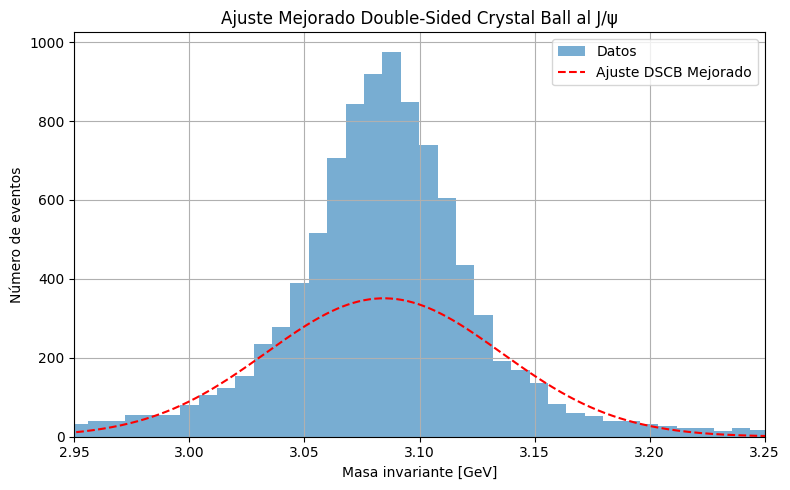

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Calcular masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Filtros sin pt (como pediste)
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Región centrada (pico del J/ψ)
region = (filtered['invariant_mass'] > 2.9) & (filtered['invariant_mass'] < 3.3)
selected_data = filtered[region]['invariant_mass']

# Histograma (50 bins)
hist_values, bin_edges = np.histogram(selected_data, bins=60)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función Double-Sided Crystal Ball (DSCB)
def double_crystal_ball(x, A, mu, sigma, alphaL, nL, alphaR, nR):
    t = (x - mu) / sigma
    result = np.zeros_like(t)

    mask_left = t < -alphaL
    safe_base_left = np.maximum(nL / abs(alphaL) - abs(t[mask_left]), 1e-10)
    result[mask_left] = A * ((nL / abs(alphaL)) ** nL) * np.exp(-alphaL ** 2 / 2) * safe_base_left ** -nL

    mask_right = t > alphaR
    safe_base_right = np.maximum(nR / abs(alphaR) - abs(t[mask_right]), 1e-10)
    result[mask_right] = A * ((nR / abs(alphaR)) ** nR) * np.exp(-alphaR ** 2 / 2) * safe_base_right ** -nR

    mask_center = (~mask_left) & (~mask_right)
    result[mask_center] = A * np.exp(-0.5 * t[mask_center] ** 2)

    return result

# Valores iniciales mejorados y límites adecuados
p0 = [np.max(hist_values), 3.1, 0.02, 1.5, 3, 1.5, 3]
lower_bounds = [0, 3.05, 0.005, 0.5, 1.1, 0.5, 1.1]
upper_bounds = [np.inf, 3.15, 0.08, 5, 10, 5, 10]

# Ajuste
popt, pcov = curve_fit(
    double_crystal_ball,
    bin_centers,
    hist_values,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
    maxfev=300000
)

# Mostrar resultados
param_names = ['A', 'mu', 'sigma', 'alphaL', 'nL', 'alphaR', 'nR']
param_errors = np.sqrt(np.diag(pcov))

for name, value, error in zip(param_names, popt, param_errors):
    print(f"{name} = {value:.6f} ± {error:.6f}")

print("\nMasa central (mu) = {:.6f} ± {:.6f} GeV".format(popt[1], param_errors[1]))
print("Ancho (sigma) = {:.6f} ± {:.6f} GeV".format(popt[2], param_errors[2]))

# Gráfica
plt.figure(figsize=(8, 5))
plt.hist(selected_data, bins=50, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 500)
plt.plot(
    x_fit,
    double_crystal_ball(x_fit, *popt),
    'r--',
    label='Ajuste DSCB Mejorado'
)
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste Mejorado Double-Sided Crystal Ball al J/ψ')
plt.xlim(2.95, 3.25)  # Opcional: enfocar cerca del pico
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


A = 258.1539 ± 30.7603
mu = 3.0844 ± 0.0071
sigma = 0.0517 ± 0.0071
alphaL = 3.7143 ± 0.0000
nL = 1.2302 ± 0.0000
alphaR = 4.1168 ± 0.0000
nR = 1.1292 ± 0.0000

Masa central (mu) = 3.0844 ± 0.0071 GeV
Ancho (sigma) = 0.0517 ± 0.0071 GeV


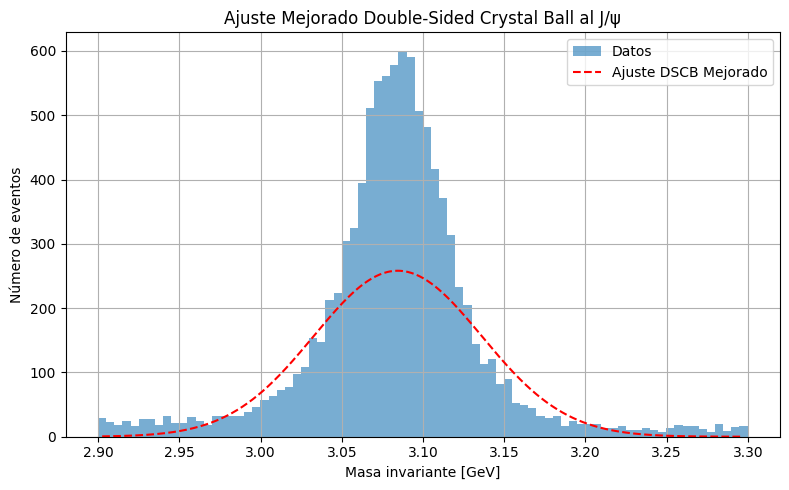

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Calcular la masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Filtros (sin corte en pt, como pediste)
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Región más centrada (solo el pico del J/ψ)
region = (filtered['invariant_mass'] > 2.9) & (filtered['invariant_mass'] < 3.3)
selected_data = filtered[region]['invariant_mass']

# Histograma
hist_values, bin_edges = np.histogram(selected_data, bins=80)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función Double-Sided Crystal Ball (DSCB)
def double_crystal_ball(x, A, mu, sigma, alphaL, nL, alphaR, nR):
    t = (x - mu) / sigma
    result = np.zeros_like(t)

    mask_left = t < -alphaL
    safe_base_left = np.maximum(nL / abs(alphaL) - abs(t[mask_left]), 1e-10)
    result[mask_left] = A * ((nL / abs(alphaL)) ** nL) * np.exp(-alphaL ** 2 / 2) * safe_base_left ** -nL

    mask_right = t > alphaR
    safe_base_right = np.maximum(nR / abs(alphaR) - abs(t[mask_right]), 1e-10)
    result[mask_right] = A * ((nR / abs(alphaR)) ** nR) * np.exp(-alphaR ** 2 / 2) * safe_base_right ** -nR

    mask_center = (~mask_left) & (~mask_right)
    result[mask_center] = A * np.exp(-0.5 * t[mask_center] ** 2)

    return result

# Ajuste mejorado (valores iniciales realistas y límites ajustados)
p0 = [np.max(hist_values), 3.1, 0.02, 1.5, 2, 1.5, 2]  # mejores iniciales
lower_bounds = [0, 2.9, 0.001, 0.1, 1.1, 0.1, 1.1]     # límites realistas
upper_bounds = [np.inf, 3.3, 0.1, 5.0, 10.0, 5.0, 10.0]

popt, pcov = curve_fit(
    double_crystal_ball,
    bin_centers,
    hist_values,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
    maxfev=100000
)

# Mostrar resultados
param_names = ['A', 'mu', 'sigma', 'alphaL', 'nL', 'alphaR', 'nR']
param_errors = np.sqrt(np.diag(pcov))

for name, value, error in zip(param_names, popt, param_errors):
    print(f"{name} = {value:.4f} ± {error:.4f}")

print("\nMasa central (mu) = {:.4f} ± {:.4f} GeV".format(popt[1], param_errors[1]))
print("Ancho (sigma) = {:.4f} ± {:.4f} GeV".format(popt[2], param_errors[2]))

# Gráfica del ajuste
plt.figure(figsize=(8, 5))
plt.hist(selected_data, bins=80, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 500)
plt.plot(
    x_fit,
    double_crystal_ball(x_fit, *popt),
    'r--',
    label='Ajuste DSCB Mejorado'
)
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste Mejorado Double-Sided Crystal Ball al J/ψ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


A = 201.7299 ± 0.0000
mu = 3.0816 ± 0.0000
sigma = 0.1151 ± 0.0463
alphaL = 4.9999 ± 0.0000
nL = 1.1000 ± 0.0000
alphaR = 4.5224 ± 0.0000
nR = 1.1413 ± 0.0000

Masa central (mu) = 3.0816 ± 0.0000 GeV
Ancho (sigma) = 0.1151 ± 0.0463 GeV


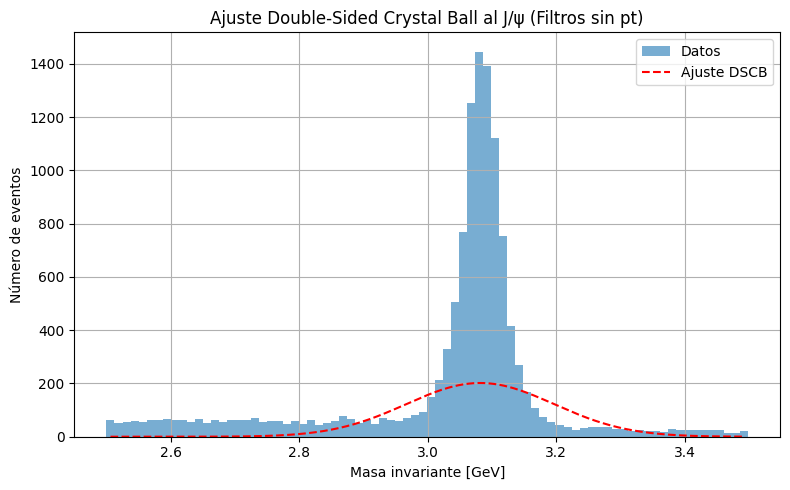

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Calcular masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Aplicar filtros (sin cortar en pt)
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Seleccionar la región del J/ψ (opcional pero recomendado)
region = (filtered['invariant_mass'] > 2.5) & (filtered['invariant_mass'] < 3.5)
selected_data = filtered[region]['invariant_mass']

# Histograma
hist_values, bin_edges = np.histogram(selected_data, bins=80)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función Double-Sided Crystal Ball (DSCB)
def double_crystal_ball(x, A, mu, sigma, alphaL, nL, alphaR, nR):
    t = (x - mu) / sigma
    result = np.zeros_like(t)

    mask_left = t < -alphaL
    safe_base_left = np.maximum(nL / abs(alphaL) - abs(t[mask_left]), 1e-10)
    result[mask_left] = A * ((nL / abs(alphaL)) ** nL) * np.exp(-alphaL ** 2 / 2) * safe_base_left ** -nL

    mask_right = t > alphaR
    safe_base_right = np.maximum(nR / abs(alphaR) - abs(t[mask_right]), 1e-10)
    result[mask_right] = A * ((nR / abs(alphaR)) ** nR) * np.exp(-alphaR ** 2 / 2) * safe_base_right ** -nR

    mask_center = (~mask_left) & (~mask_right)
    result[mask_center] = A * np.exp(-0.5 * t[mask_center] ** 2)

    return result

# Ajuste
p0 = [np.max(hist_values), 3.1, 0.05, 1.5, 2, 1.5, 2]
lower_bounds = [0, 2.5, 0.001, 0.1, 1.1, 0.1, 1.1]
upper_bounds = [np.inf, 3.5, 1.0, 5, 10, 5, 10]

popt, pcov = curve_fit(
    double_crystal_ball,
    bin_centers,
    hist_values,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
    maxfev=1000000  # Más iteraciones permitidas
)

# Mostrar resultados
param_names = ['A', 'mu', 'sigma', 'alphaL', 'nL', 'alphaR', 'nR']
param_errors = np.sqrt(np.diag(pcov))

for name, value, error in zip(param_names, popt, param_errors):
    print(f"{name} = {value:.4f} ± {error:.4f}")

print("\nMasa central (mu) = {:.4f} ± {:.4f} GeV".format(popt[1], param_errors[1]))
print("Ancho (sigma) = {:.4f} ± {:.4f} GeV".format(popt[2], param_errors[2]))

# Gráfica del ajuste
plt.figure(figsize=(8, 5))
plt.hist(selected_data, bins=80, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 500)
plt.plot(
    x_fit,
    double_crystal_ball(x_fit, *popt),
    'r--',
    label='Ajuste DSCB'
)
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste Double-Sided Crystal Ball al J/ψ (Filtros sin pt)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Masa central (mu): 3.0836 ± 0.0018 GeV
Ancho (sigma): 0.0383 ± 0.0019 GeV


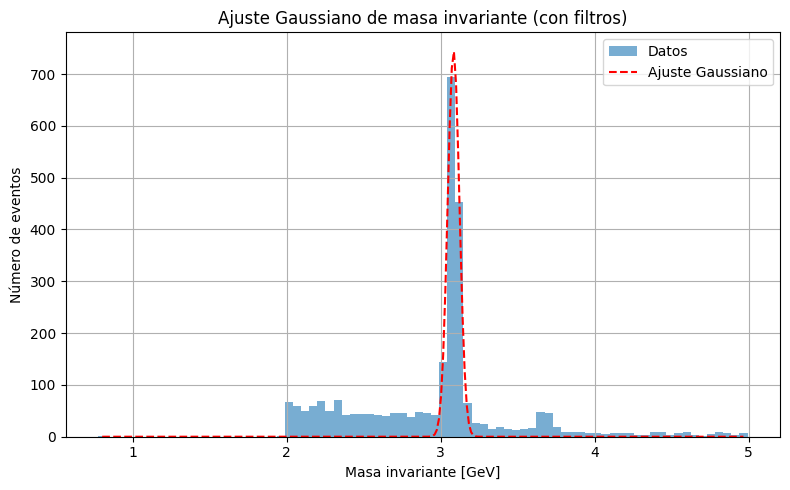

In [123]:


# Suponiendo que ya cargaste tu DataFrame 'particles'

# ✅ Filtros:
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# ✅ Cálculo de la masa invariante:
delta_eta = filtered['eta1'] - filtered['eta2']
delta_phi = filtered['phi1'] - filtered['phi2']
mass_squared = 2 * filtered['pt1'] * filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
filtered['invariant_mass'] = np.sqrt(mass_squared)

# ✅ Histograma para el ajuste:
hist_values, bin_edges = np.histogram(filtered['invariant_mass'], bins=80)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# ✅ Función gaussiana:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

# ✅ Ajuste:
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[500, 3.1, 0.05])
A, mu, sigma = popt
mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:]

# ✅ Mostrar resultados:
print(f"Masa central (mu): {mu:.4f} ± {mu_err:.4f} GeV")
print(f"Ancho (sigma): {sigma:.4f} ± {sigma_err:.4f} GeV")

# ✅ Graficar:
plt.figure(figsize=(8, 5))
plt.hist(filtered['invariant_mass'], bins=80, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 300)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r--', label='Ajuste Gaussiano')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste Gaussiano de masa invariante (con filtros)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Masa central (mu): 3.0836 ± 0.0013 GeV
Ancho (sigma): 0.0368 ± 0.0014 GeV


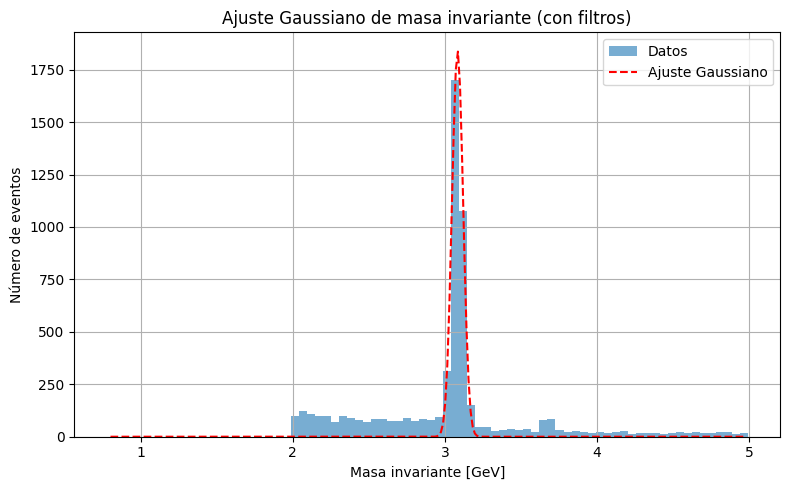

In [124]:


# Suponiendo que ya cargaste tu DataFrame 'particles'

# ✅ Filtros:
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
   ((particles['pt1'] / particles['pt2']).between(0.8, 1.2)) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# ✅ Cálculo de la masa invariante:
delta_eta = filtered['eta1'] - filtered['eta2']
delta_phi = filtered['phi1'] - filtered['phi2']
mass_squared = 2 * filtered['pt1'] * filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
filtered['invariant_mass'] = np.sqrt(mass_squared)

# ✅ Histograma para el ajuste:
hist_values, bin_edges = np.histogram(filtered['invariant_mass'], bins=80)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# ✅ Función gaussiana:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

# ✅ Ajuste:
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[500, 3.1, 0.05])
A, mu, sigma = popt
mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:]

# ✅ Mostrar resultados:
print(f"Masa central (mu): {mu:.4f} ± {mu_err:.4f} GeV")
print(f"Ancho (sigma): {sigma:.4f} ± {sigma_err:.4f} GeV")

# ✅ Graficar:
plt.figure(figsize=(8, 5))
plt.hist(filtered['invariant_mass'], bins=80, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 300)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r--', label='Ajuste Gaussiano')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste Gaussiano de masa invariante (con filtros)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


A = 605.1545 ± 173.7989
mu = 3.0397 ± 0.1320
sigma = 0.3979 ± 0.1320
alphaL = 4.8482 ± 0.0000
nL = 1.1127 ± 0.0000
alphaR = 4.8556 ± 0.0000
nR = 1.1120 ± 0.0000

Resultados clave:
Masa central (mu) = 3.0397 ± 0.1320 GeV
Ancho (sigma) = 0.3979 ± 0.1320 GeV


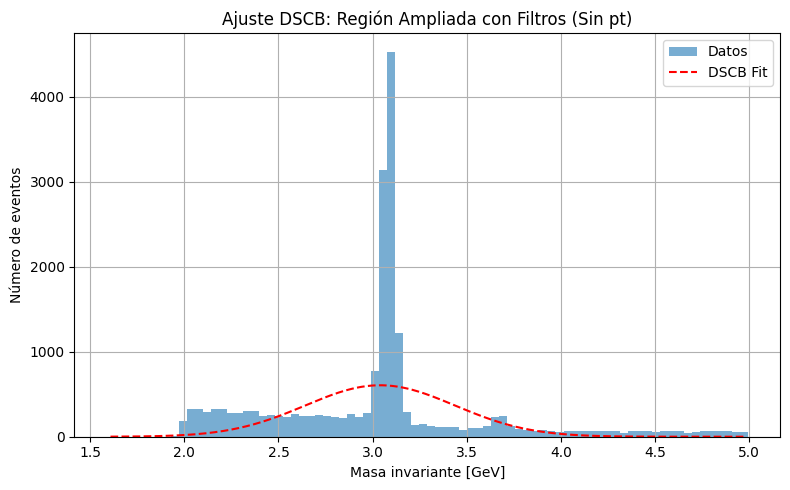

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Calcular la masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Filtros sin cortar en pt
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1)
].copy()

# Seleccionar región amplia
region = (filtered['invariant_mass'] > 1.0) & (filtered['invariant_mass'] < 5.0)
selected_data = filtered[region]['invariant_mass']

# Histograma
hist_values, bin_edges = np.histogram(selected_data, bins=80)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función DSCB protegida
def double_crystal_ball(x, A, mu, sigma, alphaL, nL, alphaR, nR):
    t = (x - mu) / sigma
    result = np.zeros_like(t)

    mask_left = t < -alphaL
    safe_base_left = np.maximum(nL / abs(alphaL) - abs(t[mask_left]), 1e-10)
    result[mask_left] = A * ((nL / abs(alphaL)) ** nL) * np.exp(-alphaL ** 2 / 2) * safe_base_left ** -nL

    mask_right = t > alphaR
    safe_base_right = np.maximum(nR / abs(alphaR) - abs(t[mask_right]), 1e-10)
    result[mask_right] = A * ((nR / abs(alphaR)) ** nR) * np.exp(-alphaR ** 2 / 2) * safe_base_right ** -nR

    mask_center = (~mask_left) & (~mask_right)
    result[mask_center] = A * np.exp(-0.5 * t[mask_center] ** 2)

    return result

# Ajuste DSCB directo (sin gaussiana previa)
p0_dscb = [np.max(hist_values), 3.1, 0.1, 1.5, 2, 1.5, 2]
lower_bounds = [0, 1.0, 0.001, 0.1, 1.1, 0.1, 1.1]
upper_bounds = [np.inf, 5.0, 1.0, 5, 10, 5, 10]

popt_dscb, pcov_dscb = curve_fit(
    double_crystal_ball,
    bin_centers,
    hist_values,
    p0=p0_dscb,
    bounds=(lower_bounds, upper_bounds),
    maxfev=30000
)

# Mostrar parámetros
param_names = ['A', 'mu', 'sigma', 'alphaL', 'nL', 'alphaR', 'nR']
param_errors = np.sqrt(np.diag(pcov_dscb))

for name, value, error in zip(param_names, popt_dscb, param_errors):
    print(f"{name} = {value:.4f} ± {error:.4f}")

print("\nResultados clave:")
print(f"Masa central (mu) = {popt_dscb[1]:.4f} ± {param_errors[1]:.4f} GeV")
print(f"Ancho (sigma) = {popt_dscb[2]:.4f} ± {param_errors[2]:.4f} GeV")

# Graficar ajuste
plt.figure(figsize=(8, 5))
plt.hist(selected_data, bins=80, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 500)
plt.plot(
    x_fit,
    double_crystal_ball(x_fit, *popt_dscb),
    'r--',
    label='DSCB Fit'
)
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste DSCB: Región Ampliada con Filtros (Sin pt)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


A = 628.2957 ± 215.8252
mu = 3.1599 ± 25.9736
sigma = 0.3894 ± 0.1482
alphaL = 4.1436 ± 0.0000
nL = 3.4277 ± 0.0000
alphaR = 4.6618 ± 0.0000
nR = 1.1057 ± 0.0000
sigma_smear = 0.0011 ± 39.6961

Resultados clave:
Masa central (mu) = 3.1599 ± 25.9736 GeV
Ancho (sigma) = 0.3894 ± 0.1482 GeV
Smearing Gaussiano = 0.0011 ± 39.6961 GeV


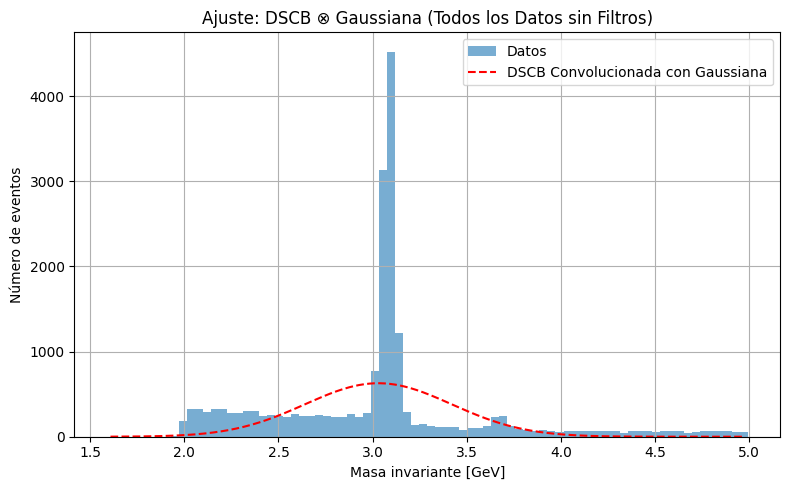

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
from scipy.interpolate import interp1d

# Calcular la masa invariante sin filtros
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Región ampliada sin filtros
region = (particles['invariant_mass'] > 1.0) & (particles['invariant_mass'] < 5.0)
selected_data = particles[region]['invariant_mass']

# Histograma
hist_values, bin_edges = np.histogram(selected_data, bins=80)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función DSCB protegida
def double_crystal_ball(x, A, mu, sigma, alphaL, nL, alphaR, nR):
    t = (x - mu) / sigma
    result = np.zeros_like(t)

    mask_left = t < -alphaL
    safe_base_left = np.maximum(nL / abs(alphaL) - abs(t[mask_left]), 1e-10)
    result[mask_left] = A * ((nL / abs(alphaL)) ** nL) * np.exp(-alphaL ** 2 / 2) * safe_base_left ** -nL

    mask_right = t > alphaR
    safe_base_right = np.maximum(nR / abs(alphaR) - abs(t[mask_right]), 1e-10)
    result[mask_right] = A * ((nR / abs(alphaR)) ** nR) * np.exp(-alphaR ** 2 / 2) * safe_base_right ** -nR

    mask_center = (~mask_left) & (~mask_right)
    result[mask_center] = A * np.exp(-0.5 * t[mask_center] ** 2)

    return result

# Convolución DSCB ⊗ Gaussiana
def dscb_convoluted_gaussian(x, A, mu, sigma, alphaL, nL, alphaR, nR, sigma_smear):
    x_fine = np.linspace(x.min() - 3 * sigma_smear, x.max() + 3 * sigma_smear, 10 * len(x))
    dscb_vals = double_crystal_ball(x_fine, A, mu, sigma, alphaL, nL, alphaR, nR)

    gauss_kernel = np.exp(-0.5 * ((x_fine - mu) / sigma_smear) ** 2)
    gauss_kernel /= np.sum(gauss_kernel)  # Normalización

    convolved = fftconvolve(dscb_vals, gauss_kernel, mode='same')

    interpolator = interp1d(x_fine, convolved, bounds_error=False, fill_value=0)
    return interpolator(x)

# Ajuste directo (sin gaussiana previa, sin filtros)
p0 = [np.max(hist_values), 3.1, 0.1, 1.5, 2, 1.5, 2, 0.02]  # Valores iniciales razonables
lower_bounds = [0, 1.0, 0.001, 0.1, 1.1, 0.1, 1.1, 0.001]
upper_bounds = [np.inf, 5.0, 1.0, 5, 10, 5, 10, 0.2]

popt, pcov = curve_fit(
    dscb_convoluted_gaussian,
    bin_centers,
    hist_values,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
    maxfev=40000
)

# Mostrar resultados
param_names = ['A', 'mu', 'sigma', 'alphaL', 'nL', 'alphaR', 'nR', 'sigma_smear']
param_errors = np.sqrt(np.diag(pcov))

for name, value, error in zip(param_names, popt, param_errors):
    print(f"{name} = {value:.4f} ± {error:.4f}")

print("\nResultados clave:")
print(f"Masa central (mu) = {popt[1]:.4f} ± {param_errors[1]:.4f} GeV")
print(f"Ancho (sigma) = {popt[2]:.4f} ± {param_errors[2]:.4f} GeV")
print(f"Smearing Gaussiano = {popt[7]:.4f} ± {param_errors[7]:.4f} GeV")

# Graficar ajuste
plt.figure(figsize=(8, 5))
plt.hist(selected_data, bins=80, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 500)
plt.plot(
    x_fit,
    dscb_convoluted_gaussian(x_fit, *popt),
    'r--',
    label='DSCB Convolucionada con Gaussiana'
)
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste: DSCB ⊗ Gaussiana (Todos los Datos sin Filtros)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [127]:
# Aplicar los tres filtros: pseudorapidez, carga y pt
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10)
]

# Mostrar el número de eventos que cumplen todos los filtros
print(f"Eventos con |eta| < 2.4, carga opuesta y pt > 10 GeV: {len(filtered)}")


Eventos con |eta| < 2.4, carga opuesta y pt > 10 GeV: 3243


In [128]:

# Filtros comunes: |eta| < 2.4, carga opuesta, pt > 10 GeV
common_filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10)
].copy()

# Calcular masa invariante (para todos los eventos filtrados)
delta_eta = common_filtered['eta1'] - common_filtered['eta2']
delta_phi = common_filtered['phi1'] - common_filtered['phi2']
mass_squared = 2 * common_filtered['pt1'] * common_filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
common_filtered['invariant_mass'] = np.sqrt(mass_squared)

# Filtro adicional: Solo muones G-G
gg_filtered = common_filtered[
    (common_filtered['type1'] == 'G') &
    (common_filtered['type2'] == 'G')
]

# Crear gráfico
fig = go.Figure()

# Histograma sin G-G
fig.add_trace(go.Histogram(
    x=common_filtered['invariant_mass'],
    nbinsx=200,
    name='Sin filtro G-G',
    opacity=0.6
))

# Histograma con G-G
fig.add_trace(go.Histogram(
    x=gg_filtered['invariant_mass'],
    nbinsx=200,
    name='Con filtro G-G',
    opacity=0.6
))

# Añadir línea vertical en la masa del J/ψ (~3.0969 GeV)
fig.add_vline(
    x=3.0969,
    line_dash="dash",
    line_color="red",
    annotation_text="J/ψ",
    annotation_position="top right"
)

# Añadir línea vertical en la masa del ψ(2S) (~3.6861 GeV)
fig.add_vline(
    x=3.6861,
    line_dash="dash",
    line_color="blue",
    annotation_text="ψ(2S)",
    annotation_position="top right"
)

# Configurar diseño del gráfico
fig.update_layout(
    title='Comparación de masa invariante con y sin filtro G-G (con líneas en J/ψ y ψ(2S))',
    xaxis_title='Masa invariante [GeV]',
    yaxis_title='Número de eventos',
    barmode='overlay',
    bargap=0.05
)

fig.show()

# Mostrar conteos de eventos
print(f"Eventos con todos los filtros, sin G-G: {len(common_filtered)}")
print(f"Eventos con todos los filtros, con G-G: {len(gg_filtered)}")

Eventos con todos los filtros, sin G-G: 3243
Eventos con todos los filtros, con G-G: 2718


Masa central (mu): 3.0846 ± 0.0010 GeV
Ancho (sigma): 0.0318 ± 0.0010 GeV


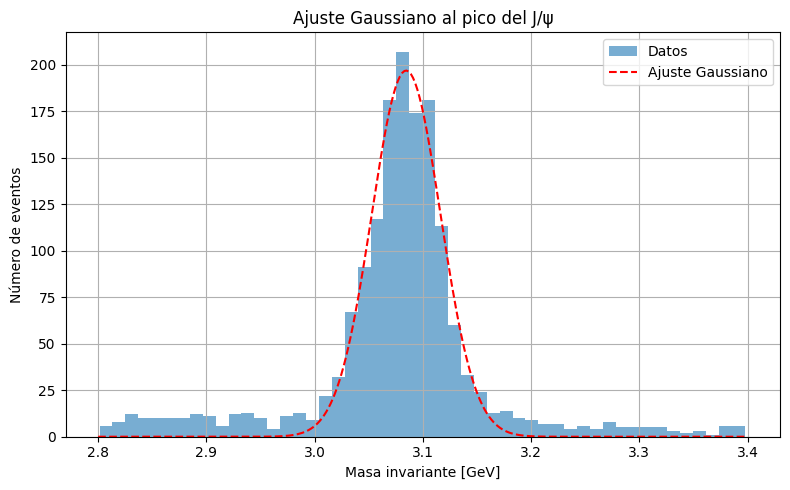

In [129]:
# Filtros comunes + G-G
filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Calcular masa invariante
delta_eta = filtered['eta1'] - filtered['eta2']
delta_phi = filtered['phi1'] - filtered['phi2']
mass_squared = 2 * filtered['pt1'] * filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
filtered['invariant_mass'] = np.sqrt(mass_squared)

# Filtrar eventos alrededor del J/ψ para el ajuste (ej.: 2.8 a 3.4 GeV)
region = filtered[(filtered['invariant_mass'] > 2.8) & (filtered['invariant_mass'] < 3.4)]

# Crear histograma para el ajuste
hist_values, bin_edges = np.histogram(region['invariant_mass'], bins=50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Definir función Gaussiana
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Ajustar
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[100, 3.1, 0.05])
A, mu, sigma = popt
mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:]

# Mostrar parámetros
print(f"Masa central (mu): {mu:.4f} ± {mu_err:.4f} GeV")
print(f"Ancho (sigma): {sigma:.4f} ± {sigma_err:.4f} GeV")

# Graficar histograma + ajuste
plt.figure(figsize=(8, 5))
plt.hist(region['invariant_mass'], bins=50, alpha=0.6, label='Datos')
x_fit = np.linspace(2.8, 3.4, 300)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r--', label='Ajuste Gaussiano')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste Gaussiano al pico del J/ψ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [130]:

# Filtro adicional: Energía mínima por muón
energy_filtered = gg_filtered[
    (gg_filtered['E1'] > 1.5) &
    (gg_filtered['E2'] > 1.5)
]

print(f"Eventos después del filtro de energía (E1, E2 > 1.5 GeV): {len(energy_filtered)}")


Eventos después del filtro de energía (E1, E2 > 1.5 GeV): 2718


In [131]:
# Filtros comunes: |eta| < 2.4, carga opuesta, y pt > 10 GeV
common_filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10)
].copy()

# Calcular masa invariante (para todos los eventos con filtros comunes)
delta_eta = common_filtered['eta1'] - common_filtered['eta2']
delta_phi = common_filtered['phi1'] - common_filtered['phi2']
mass_squared = 2 * common_filtered['pt1'] * common_filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
common_filtered['invariant_mass'] = np.sqrt(mass_squared)

# Filtrar solo muones G-G
gg_filtered = common_filtered[
    (common_filtered['type1'] == 'G') &
    (common_filtered['type2'] == 'G')
]

# Graficar comparación de histogramas
fig = go.Figure()

# Histograma sin G-G (todos los muones)
fig.add_trace(go.Histogram(
    x=common_filtered['invariant_mass'],
    nbinsx=80,
    name='Todos los muones (sin G-G)',
    opacity=0.6
))

# Histograma con G-G
fig.add_trace(go.Histogram(
    x=gg_filtered['invariant_mass'],
    nbinsx=80,
    name='Solo muones G-G',
    opacity=0.6
))

fig.update_layout(
    title='Comparación: masa invariante con y sin filtro G-G',
    xaxis_title='Masa invariante [GeV]',
    yaxis_title='Número de eventos',
    barmode='overlay',
    bargap=0.05
)

fig.show()

# Mostrar conteos de eventos
print(f"Eventos con |eta| < 2.4, carga opuesta y pt > 10 GeV (sin G-G): {len(common_filtered)}")
print(f"Eventos con |eta| < 2.4, carga opuesta, pt > 10 GeV y muones G-G: {len(gg_filtered)}")


Eventos con |eta| < 2.4, carga opuesta y pt > 10 GeV (sin G-G): 3243
Eventos con |eta| < 2.4, carga opuesta, pt > 10 GeV y muones G-G: 2718


In [132]:

# Calcular diferencia en phi (ajustada al rango [-pi, pi])
delta_phi = particles['phi1'] - particles['phi2']
delta_phi = np.mod(delta_phi + np.pi, 2 * np.pi) - np.pi

# Histograma de la diferencia en phi
fig = px.histogram(
    x=delta_phi,
    nbins=80,
    title='Histograma de Δφ',
    labels={'x': 'Δφ = φ1 - φ2 [rad]', 'y': 'Número de eventos'}
)

fig.update_layout(bargap=0.05)
fig.show()

In [133]:
# Filtro: pares con carga opuesta
charge_filtered = particles[(particles['type1'] == 'G') &
    (particles['type2'] == 'G')]



# Contar eventos después de ambos filtros
print(f"Número de eventos con G-G: {len(charge_filtered)}")


Número de eventos con G-G: 17240


In [134]:
# Filtro: pares con carga opuesta
charge_filtered = particles[(particles['eta1'] < 2.4) &
    (particles['eta2'] < 2.4)]



# Contar eventos después de ambos filtros
print(f"Número de eventos con eta <2.4: {len(charge_filtered)}")


Número de eventos con eta <2.4: 19999


In [135]:

# Filtro: carga opuesta y |eta| < 2.4 para ambos muones
filtered = particles[
    (particles['Q1'] * particles['Q2'] == -1) &
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4)
].copy()

# Calcular masa invariante (con los filtros aplicados)
delta_eta = filtered['eta1'] - filtered['eta2']
delta_phi = filtered['phi1'] - filtered['phi2']
mass_squared = 2 * filtered['pt1'] * filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
filtered['invariant_mass'] = np.sqrt(mass_squared)

# Graficar histograma interactivo
fig = px.histogram(
    filtered,
    x='invariant_mass',
    nbins=80,
    title='Masa invariante (filtro: carga opuesta y |eta| < 2.4)',
    labels={'invariant_mass': 'Masa invariante [GeV]'}
)

# Añadir línea en la masa del J/ψ (3.0969 GeV)
fig.add_vline(
    x=3.0969,
    line_dash="dash",
    line_color="red",
    annotation_text="J/ψ",
    annotation_position="top right"
)

fig.update_layout(bargap=0.05)
fig.show()

# Mostrar cantidad de eventos restantes
print(f"Número de eventos con carga opuesta y |eta| < 2.4: {len(filtered)}")

Número de eventos con carga opuesta y |eta| < 2.4: 19999


In [136]:

# Filtro: solo pares con carga opuesta
charge_filtered = particles[particles['Q1'] * particles['Q2'] == -1]

# Contar número de candidatos con carga opuesta
print(f"Número de eventos con carga opuesta: {len(charge_filtered)}")

Número de eventos con carga opuesta: 20000


In [137]:
# Filtro: pares con carga opuesta
charge_filtered = particles[particles['Q1'] * particles['Q2'] == -1]

# Filtro adicional: pt1 > 10 GeV y pt2 > 10 GeV
pt_filtered = charge_filtered[
    (charge_filtered['pt1'] > 10) &
    (charge_filtered['pt2'] > 10)
]

# Contar eventos después de ambos filtros
print(f"Número de eventos con carga opuesta: {len(charge_filtered)}")
print(f"Número de eventos con carga opuesta y pt > 10 GeV: {len(pt_filtered)}")


Número de eventos con carga opuesta: 20000
Número de eventos con carga opuesta y pt > 10 GeV: 3243


In [138]:
charge_filtered = particles[particles['Q1'] * particles['Q2'] == -1]

In [139]:
# Filtro 1: pares con carga opuesta
charge_filtered = particles[particles['Q1'] * particles['Q2'] == -1]

# Filtro 2: pt > 10 GeV para ambos
pt_filtered = charge_filtered[
    (charge_filtered['pt1'] > 10) &
    (charge_filtered['pt2'] > 10)
]

# Filtro 3: ambos muones tipo Global (G-G)
gg_filtered = pt_filtered[
    (pt_filtered['type1'] == 'G') &
    (pt_filtered['type2'] == 'G')
]

# Mostrar cantidad de eventos después de cada filtro
print(f"Número de eventos con carga opuesta: {len(charge_filtered)}")
print(f"Número de eventos con carga opuesta y pt > 10 GeV: {len(pt_filtered)}")
print(f"Número de eventos con carga opuesta, pt > 10 GeV y muones G-G: {len(gg_filtered)}")


Número de eventos con carga opuesta: 20000
Número de eventos con carga opuesta y pt > 10 GeV: 3243
Número de eventos con carga opuesta, pt > 10 GeV y muones G-G: 2718


In [140]:
import plotly.graph_objects as go

# Aplicar todos los filtros: |eta| < 2.4, carga opuesta, pt > 10 GeV y G-G
energy_filtered = particles[
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4) &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10) &
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G')
].copy()

# Crear histograma combinado de E1 y E2
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=energy_filtered['E1'],
    nbinsx=80,
    name='E1 [GeV]',
    opacity=0.6
))

fig.add_trace(go.Histogram(
    x=energy_filtered['E2'],
    nbinsx=80,
    name='E2 [GeV]',
    opacity=0.6
))

fig.update_layout(
    title='Histograma de energía E1 y E2 (con todos los filtros incluyendo G-G)',
    xaxis_title='Energía [GeV]',
    yaxis_title='Número de eventos',
    barmode='overlay',
    bargap=0.05
)

fig.show()


In [141]:

# Filtro: pares con carga opuesta
charge_filtered = particles[particles['Q1'] * particles['Q2'] == -1]

# Calcular masa invariante
delta_eta = charge_filtered['eta1'] - charge_filtered['eta2']
delta_phi = charge_filtered['phi1'] - charge_filtered['phi2']
mass_squared = 2 * charge_filtered['pt1'] * charge_filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
charge_filtered['invariant_mass'] = np.sqrt(mass_squared)

# Crear histograma con Plotly Express
fig = px.histogram(
    charge_filtered,
    x='invariant_mass',
    nbins=200,
    title='Masa invariante (sólo carga opuesta) con línea del J/ψ',
    labels={'invariant_mass': 'Masa invariante [GeV]'}
)

# Añadir línea vertical en la masa del J/ψ
fig.add_vline(
    x=3.0969,
    line_dash="dash",
    line_color="red",
    annotation_text="J/ψ",
    annotation_position="top right"
)

fig.update_layout(bargap=0.05)
fig.show()

In [142]:
# Calcular masa invariante sin filtros
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Graficar histograma con Plotly Express
fig = px.histogram(
    particles,
    x='invariant_mass',
    nbins=300,
    title='Masa invariante (todos los eventos, sin filtros)',
    labels={'invariant_mass': 'Masa invariante [GeV]'}
)

fig.update_layout(bargap=0.05)
fig.show()

In [143]:

# Filtro: muones globales (G-G) y de carga opuesta (Q1 × Q2 = -1)
filtered = particles[
     (particles['type1'] == 'G') &
    (particles['type2'] == 'G') &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10) &
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4)
].copy()

# Preparar DataFrame para graficar pt1 y pt2 juntos
pt_data = pd.DataFrame({
    'pt': pd.concat([filtered['pt1'], filtered['pt2']], ignore_index=True),
    'muon': ['pt1'] * len(filtered) + ['pt2'] * len(filtered)
})

# Graficar con Plotly
fig = px.histogram(pt_data, x='pt', color='muon', barmode='overlay',
                   nbins=40,
                   labels={'pt': 'pt [GeV]'},
                   title='Histograma de pt1 y pt2 (G-G, carga opuesta)')
fig.update_layout(bargap=0.1)
fig.show()


In [144]:
particles['pt_max'] = np.maximum(particles['pt1'], particles['pt1'])
px.histogram(particles, x='pt_max', nbins=100, title='Distribución de pt máximo entre ambos muones')


In [145]:
# Total de muones positivos (charge = +1)
muones_positivos1 = (particles['Q1'] == 1).sum()
muones_positivos2 = (particles['Q2'] == 1).sum()
# Total de muones negativos (charge = -1)
muones_negativos1 = (particles['Q1'] == -1).sum()
muones_negativos2 = (particles['Q2'] == -1).sum()

#TOTAL TOTAL
muones_positivos= (muones_positivos1 + muones_positivos2)
muones_negativos= (muones_negativos1 + muones_negativos2)

print(f"Total de mu+_1 : {muones_positivos1}")
print(f"Total de mu−_1 : {muones_negativos1}")
print(f"Total de mu+_2 : {muones_positivos2}")
print(f"Total de mu−_2 : {muones_negativos2}")

#Total TOTAL
print(f"Total de mu+ : {muones_positivos}")
print(f"Total de mu- : {muones_negativos}")



Total de mu+_1 : 11853
Total de mu−_1 : 8147
Total de mu+_2 : 8147
Total de mu−_2 : 11853
Total de mu+ : 20000
Total de mu- : 20000


CHECAR LA MASA INVARIANTE Y VER QUE ES

In [146]:
# Contar cuántos muones globales hay (muon1 y muon2)
global_muons = (particles['type1'] == 'G').sum() + (particles['type2'] == 'G').sum()

# Contar cuántos muones trackers hay (muon1 y muon2)
tracker_muons = (particles['type1'] == 'T').sum() + (particles['type2'] == 'T').sum()

print(f"Total de muones Global (G): {global_muons}")
print(f"Total de muones Tracker (T): {tracker_muons}")


Total de muones Global (G): 37240
Total de muones Tracker (T): 2760


In [147]:
eventos_filtrados = particles[
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G') &
    (particles['Q1'] * particles['Q2'] == -1)
]

print(f"Número de eventos con muones Global-Global y carga opuesta: {len(eventos_filtrados)}")



Número de eventos con muones Global-Global y carga opuesta: 17240


CALCULO DE LA MASA INVARIANTE

In [148]:
#MASA INVARIANTE
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']

mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

#Graficar
fig = px.histogram(particles, x='invariant_mass', nbins=60,
                   title='Masa invariante de dos muones',
                   labels={'invariant_mass': 'Masa invariante [GeV]'})
fig.update_layout(bargap=0.05)
fig.show()


In [149]:
# Filtrar eventos con ambos muones de tipo Global
gg_events = particles[(particles['type1'] == 'G') & (particles['type2'] == 'G')].copy()

# Calcular masa invariante solo para G-G
delta_eta = gg_events['eta1'] - gg_events['eta2']
delta_phi = gg_events['phi1'] - gg_events['phi2']

mass_squared = 2 * gg_events['pt1'] * gg_events['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
gg_events['invariant_mass'] = np.sqrt(mass_squared)

# Graficar
fig = px.histogram(gg_events, x='invariant_mass', nbins=60,
                   title='Masa invariante (muones Global-Global)',
                   labels={'invariant_mass': 'Masa invariante [GeV]'})
fig.update_layout(bargap=0.05)
fig.show()


Masa central (mu): 3.0849 ± 0.0008 GeV
Ancho (sigma): 0.0310 ± 0.0008 GeV


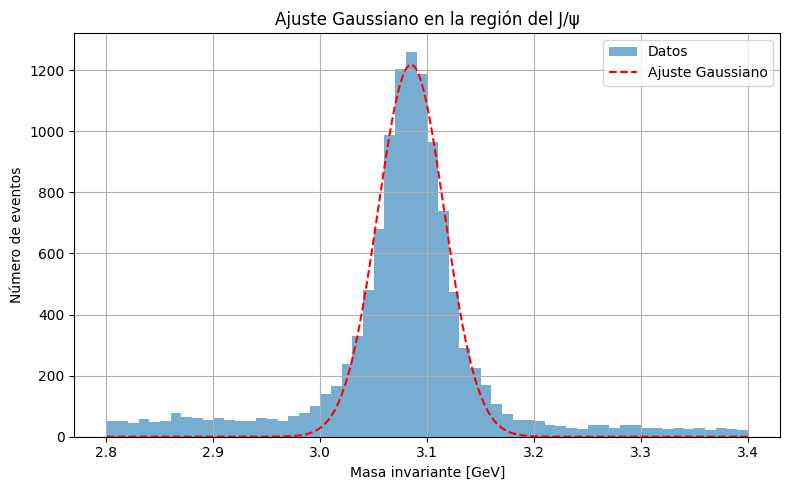

In [150]:

# Calcular masa invariante
delta_eta = particles['eta1'] - particles['eta2']
delta_phi = particles['phi1'] - particles['phi2']
mass_squared = 2 * particles['pt1'] * particles['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
particles['invariant_mass'] = np.sqrt(mass_squared)

# Filtrar región del J/ψ
region = particles[(particles['invariant_mass'] > 2.8) & (particles['invariant_mass'] < 3.4)]

# Histograma
hist_values, bin_edges = np.histogram(region['invariant_mass'], bins=60, range=(2.8, 3.4))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función gaussiana
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2))

# Ajustar curva
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[1000, 3.1, 0.05])
A, mu, sigma = popt
mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:]

# Mostrar resultados del ajuste
print(f"Masa central (mu): {mu:.4f} ± {mu_err:.4f} GeV")
print(f"Ancho (sigma): {sigma:.4f} ± {sigma_err:.4f} GeV")

# Graficar histograma + ajuste
plt.figure(figsize=(8,5))
plt.hist(region['invariant_mass'], bins=60, range=(2.8, 3.4), alpha=0.6, label='Datos')
x_fit = np.linspace(2.8, 3.4, 300)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r--', label='Ajuste Gaussiano')
plt.title('Ajuste Gaussiano en la región del J/ψ')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

COMPARACION CON LOS DATOS DEL PDG, ENCONTRAR FILTROS PARA DISMINUIR EL WITHD

Masa central (mu): 3.0849 ± 0.0007 GeV
Ancho (sigma): 0.0305 ± 0.0007 GeV


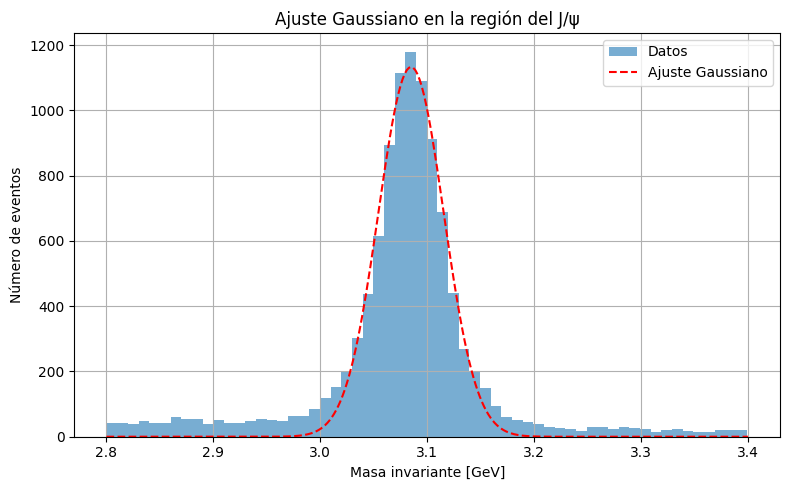

In [151]:
# Aplicar filtros: muones globales y de carga opuesta
filtered = particles[(particles['type1'] == 'G') & (particles['type2'] == 'G') & (particles['Q1'] * particles['Q2'] == -1)].copy()

# Calcular masa invariante para los eventos filtrados
delta_eta = filtered['eta1'] - filtered['eta2']
delta_phi = filtered['phi1'] - filtered['phi2']
mass_squared = 2 * filtered['pt1'] * filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
filtered['invariant_mass'] = np.sqrt(mass_squared)

# ✅ Filtro por región de masa (ej. para J/ψ)
region = filtered[(filtered['invariant_mass'] > 2.8) & (filtered['invariant_mass'] < 3.4)].copy()

# Crear histograma
hist_values, bin_edges = np.histogram(region['invariant_mass'], bins=60)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Función gaussiana
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2))

# Ajuste gaussiano
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[1000, 3.1, 0.05])
A, mu, sigma = popt
mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:]

# Resultados
print(f"Masa central (mu): {mu:.4f} ± {mu_err:.4f} GeV")
print(f"Ancho (sigma): {sigma:.4f} ± {sigma_err:.4f} GeV")

# Graficar
plt.figure(figsize=(8, 5))
plt.hist(region['invariant_mass'], bins=60, alpha=0.6, label='Datos')
x_fit = np.linspace(2.8, 3.4, 300)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r--', label='Ajuste Gaussiano')
plt.title('Ajuste Gaussiano en la región del J/ψ')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

CONTINUACION DEL ANTERIOR GRAFICA

In [152]:

# Filtrado de eventos
filtered = particles[
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G') &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10) &
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4)
].copy()

# Calcular masa invariante
delta_eta = filtered['eta1'] - filtered['eta2']
delta_phi = filtered['phi1'] - filtered['phi2']
mass_squared = 2 * filtered['pt1'] * filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
filtered['invariant_mass'] = np.sqrt(mass_squared)

# Mostrar cuántos eventos cumplen los filtros
print(f"Eventos después de todos los filtros: {len(filtered)}")

# Histograma con Plotly
fig = px.histogram(filtered, x='invariant_mass', nbins=80,
                   title='Masa invariante (muones Global-Global, pt>10 GeV, |η|<2.4, Q1·Q2 = -1)',
                   labels={'invariant_mass': 'Masa invariante [GeV]'})
fig.update_layout(bargap=0.05)
fig.show()

Eventos después de todos los filtros: 2718


Masa central (mu): 3.0836 ± 0.0018 GeV
Ancho (sigma): 0.0383 ± 0.0019 GeV


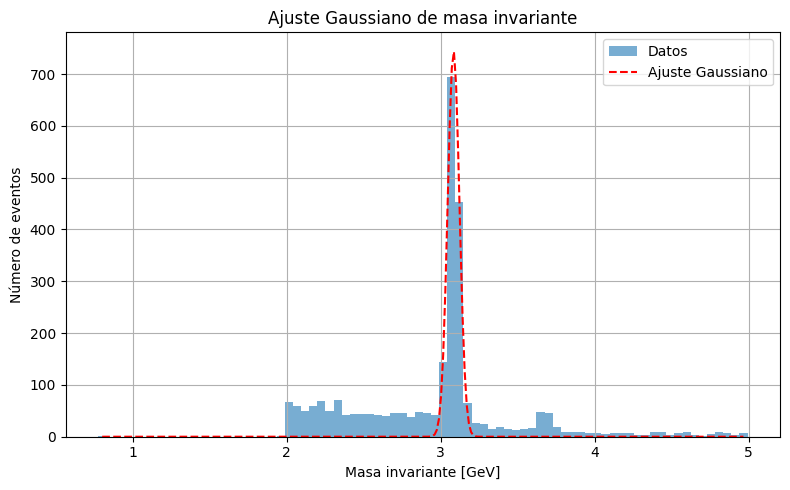

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Aplicar los filtros
filtered = particles[
    (particles['type1'] == 'G') &
    (particles['type2'] == 'G') &
    (particles['Q1'] * particles['Q2'] == -1) &
    (particles['pt1'] > 10) &
    (particles['pt2'] > 10) &
    (abs(particles['eta1']) < 2.4) &
    (abs(particles['eta2']) < 2.4)
].copy()

# Calcular masa invariante
delta_eta = filtered['eta1'] - filtered['eta2']
delta_phi = filtered['phi1'] - filtered['phi2']
mass_squared = 2 * filtered['pt1'] * filtered['pt2'] * (np.cosh(delta_eta) - np.cos(delta_phi))
filtered['invariant_mass'] = np.sqrt(mass_squared)

# Crear histograma para ajustar
hist_values, bin_edges = np.histogram(filtered['invariant_mass'], bins=80)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Definir función gaussiana
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Ajustar la gaussiana
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[500, 3.1, 0.05])
A, mu, sigma = popt
mu_err, sigma_err = np.sqrt(np.diag(pcov))[1:]

# Mostrar parámetros ajustados
print(f"Masa central (mu): {mu:.4f} ± {mu_err:.4f} GeV")
print(f"Ancho (sigma): {sigma:.4f} ± {sigma_err:.4f} GeV")

# Graficar histograma + ajuste
plt.figure(figsize=(8, 5))
plt.hist(filtered['invariant_mass'], bins=80, alpha=0.6, label='Datos')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 300)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r--', label='Ajuste Gaussiano')
plt.xlabel('Masa invariante [GeV]')
plt.ylabel('Número de eventos')
plt.title('Ajuste Gaussiano de masa invariante')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [154]:
import pandas as pd

# Suponiendo que ya cargaste tu DataFrame 'particles'
# Filtro: pares con cargas opuestas
charge_filtered = particles[particles['Q1'] * particles['Q2'] == -1]

# Conteo de cargas dentro de los eventos que cumplieron el filtro
q1_counts = charge_filtered['Q1'].value_counts()
q2_counts = charge_filtered['Q2'].value_counts()

print("Eventos con cargas opuestas (Q1 * Q2 = -1):", len(charge_filtered))

print("\nConteo de cargas en Q1 (dentro del filtro):")
print(q1_counts)

print("\nConteo de cargas en Q2 (dentro del filtro):")
print(q2_counts)


Eventos con cargas opuestas (Q1 * Q2 = -1): 20000

Conteo de cargas en Q1 (dentro del filtro):
Q1
 1    11853
-1     8147
Name: count, dtype: int64

Conteo de cargas en Q2 (dentro del filtro):
Q2
-1    11853
 1     8147
Name: count, dtype: int64
